# Deep 2014 medicare analysis using BigQuery

**Background:** Medicare provides federal health insurance to people age 65 and over, as well as to younger folks with disabilities. The Medicare dataset found on BigQuery was provided by the Centers for Medicare & Medicade Services (CMS), and the estimated state population, population demographics, and poverty rates in 2014 came from the US Census' website (census.gov). 

**Goals:**
1. Gain insights into medicare data (inpatient, outpatient, and prescriptions) for the year 2014.
2. Place medicare data into context with estimated 2014 state population and demographics for folks 65 and over.
3. Place medicare data into context with estimated 2014 state poverty rates (all ages).

Tools used in this notebook: BigQuery (APIs), Pandas, Scipy, Numpy, Geopandas, Plotly (+Matplotlib, Seaborn)
External tools: Tableau

**A few takeaways:**
- Total precription cost (65 and over): $41 billion

- Total inpatient care cost: $2.7 billion

- Total outpatient care cost: $12.1 million

- State with highest prescription rate per capita 65 and older: Kentuky 
- State with lowest prescription rate per capita 65 and older: Alaska
- Southeastern US states tend to have higher rates of poverty and higher elderly prescription rates.

**Suggestions improvement:** i) identifying trends over time by comparing datasets across multiple years, ii) using CMS data disaggregated by zipcode/county as well as race and gender.  

## Set up

### Imports

In [6]:
# uncomment if needed
# !python3 -m pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'

In [41]:
#  Standard library imports
from collections import Counter

#  Companion scripts 
from client_auth import create_client

#  BigQuery import
# from google.oauth2 import service_account
# from google.cloud import bigquery

#  Data processing and analysis
import pandas as pd
pd.set_option("display.max_columns", None) 
import numpy as np
from scipy import stats

#  Data vizualization
from matplotlib import pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objects as go
import geopandas as gpd

### Authenticate and connect to BigQuery API.

In [43]:
# def create_client():
#     key_path = "/path/to/key/filename.json"
#     scope = "https://www.googleapis.com/auth/cloud-platform"
#     credentials = service_account.Credentials.from_service_account_file(key_path, scopes=[scope],)
#     #  Create an instance of the bigquery.Client class to create the client
#     client = bigquery.Client(credentials=credentials, project=credentials.project_id,)
#     return client

#  Call function from script
client = create_client()

### Fetch medicare dataset

In [ ]:
#  Define dataset reference
project = "bigquery-public-data"
dataset_id = "medicare"
dataset_ref = client.dataset(dataset_id, project=project)

#  Fetch dataset via API request
dataset = client.get_dataset(dataset_ref)

## Data exploration

### Define helper functions

#### Query to DataFrame

In [949]:
def query_to_df(query):
    query_job = client.query(query)
    df = query_job.to_dataframe()
    return df

#### View table schema

In [954]:
def table_schema(table_name, num_results, view_schema=True):
    #  Construct a reference to a given table
    table_reference = dataset_ref.table(table_name)

    #  API request to fetch table
    table = client.get_table(table_reference)
    if view_schema:
        print(table.schema)

    df = client.list_rows(table, max_results=num_results).to_dataframe()
    return df

#### Find top N most common

In [1089]:
def most_common(df, category, N, groupby=None, counter=False):
    if counter:
        print(dict(Counter(df[category].values).most_common(N)))
    else:
        df_aggregated = df.groupby([groupby])[category].sum()
        df_aggregated = df_aggregated.reset_index()
        df_top_N = df_aggregated.sort_values(category, ascending=False).head(N)
        return df_top_N

#### Choropleth map

In [1169]:
def plot_most_common_by_state(df, locations, color, hover_name, title, fontsize, hover_data=None):
    fig = px.choropleth(df,   
                                       locations=locations,   
                                      color=color,   
                                      hover_name=hover_name, 
                                      hover_data=hover_data,
                                      locationmode = 'USA-states')

    fig.update_layout(height=300,
                                    margin={'r':0, 't':40, 'l':0 ,'b':20},
                                    title_text = title,
                                    geo_scope='world',
                                    title=dict(
                                    font=dict(family="Courier",
                                                      size=20, 
                                                      color='black')),
                                    legend=dict(x=1,y=0.5,
                                                           title=None,
                                                            traceorder="reversed",
                                                            font=dict(family="Courier",
                                                                              size=fontsize,
                                                                              color="black"),
                                                            bgcolor="white",
                                                            bordercolor="white",
                                                            borderwidth=2))

    fig.update_geos(projection_type="natural earth")

    fig.show()

### Explore medicare table schema

#### View all tables in medicare dataset

In [52]:
#  List all tables in the medicare dataset
tables = list(client.list_tables(dataset))

#  Display names of all tables w/i dataset
for table in tables:  
    print(table.table_id)

inpatient_charges_2011
inpatient_charges_2012
inpatient_charges_2013
inpatient_charges_2014
outpatient_charges_2011
outpatient_charges_2012
outpatient_charges_2013
outpatient_charges_2014
part_d_prescriber_2014
physicians_and_other_supplier_2012
physicians_and_other_supplier_2013
physicians_and_other_supplier_2014


This dataset contains inpatient, outpatient, medicare part d, and physicians data from between 2011 and 2014. Notice there's only one table contiaining prescription information from 2014. Looking at this table's schema, we find:

In [948]:
table_name = 'part_d_prescriber_2014'
df = table_schema(table_name, num_results=10, view_schema=True)
df

[SchemaField('npi', 'INTEGER', 'REQUIRED', 'National Provider Identifier', (), None), SchemaField('nppes_provider_last_org_name', 'STRING', 'NULLABLE', 'Last Name/Organization Name of the Provider', (), None), SchemaField('nppes_provider_first_name', 'STRING', 'NULLABLE', 'First Name of the Provider', (), None), SchemaField('nppes_provider_city', 'STRING', 'NULLABLE', 'City of the Provider', (), None), SchemaField('nppes_provider_state', 'STRING', 'NULLABLE', 'State Code of the Provider', (), None), SchemaField('specialty_description', 'STRING', 'NULLABLE', 'Provider Specialty Type', (), None), SchemaField('description_flag', 'STRING', 'NULLABLE', 'Source of Provider Specialty', (), None), SchemaField('drug_name', 'STRING', 'REQUIRED', 'Name of the drug', (), None), SchemaField('generic_name', 'STRING', 'NULLABLE', 'Generic name of the drug', (), None), SchemaField('bene_count', 'INTEGER', 'NULLABLE', 'Number of Medicare Beneficiaries', (), None), SchemaField('total_claim_count', 'INTE

/Users/Isabel/opt/anaconda3/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1860: UserWarning:

Cannot use bqstorage_client if max_results is set, reverting to fetching data with the REST endpoint.



,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_day_supply_ge65,total_drug_cost_ge65
0,1417953134,KELLOGG,WILLIAM,POTTSVILLE,PA,Ophthalmology,S,FML,FLUOROMETHOLONE,43,81,1970,7025.69,30,,57,,1332,4954.08
1,1366428872,NIGRO,JEFF,VANDERGRIFT,PA,Podiatry,S,SSD,SILVER SULFADIAZINE,19,22,307,193.07,19,,22,,307,193.07
2,1891724027,CHEBANOVA,ELENA,DENVER,CO,Internal Medicine,S,SSD,SILVER SULFADIAZINE,12,23,690,285.08,12,,23,,690,285.08
3,1013911098,SAUNDERS,NEIL,TOLEDO,OH,Podiatry,S,SSD,SILVER SULFADIAZINE,32,39,751,373.45,21,,24,,484,220.64
4,1093796542,GREATHOUSE,MARK,PITTSBURGH,PA,Cardiology,S,AZOR,AMLODIPINE BES/OLMESARTAN MED,15,54,2970,13844.40,15,,54,,2970,13844.40
5,1821042771,SHARMA,SARIKA,HACKENSACK,NJ,Cardiology,S,AZOR,AMLODIPINE BES/OLMESARTAN MED,12,59,2910,17583.03,12,,59,,2910,17583.03
6,1124115027,LICHTINGER,DAVID,LEESBURG,FL,Internal Medicine,S,AZOR,AMLODIPINE BES/OLMESARTAN MED,12,59,3450,18898.41,12,,59,,3450,18898.41
7,1790835940,CLARK,PRESTON,GREENSBORO,NC,Internal Medicine,S,AZOR,AMLODIPINE BES/OLMESARTAN MED,12,76,3482,19925.52,12,,76,,3482,19925.52
8,1801871470,SOLOMON,WILLIAM,SOUTHFIELD,MI,Internal Medicine,S,AZOR,AMLODIPINE BES/OLMESARTAN MED,21,96,5143,27414.76,21,,96,,5143,27414.76
9,1679591564,STANILOIU,MARIA,FOREST HILLS,NY,Internal Medicine,S,AZOR,AMLODIPINE BES/OLMESARTAN MED,18,99,4530,23313.00,18,,99,,4530,23313.00


Offhand, there are a number of columns that could be of interest, including: 
- city 
- state  
- drug name 
- generic name 
- beneficiary count (65+) 
- total claim count (65+) 
- total drug cost (65+)

### Compile medicare data of interest

#### Total number and cost of medications perscribed in each state (age 65+)

We'll calculate the sum of total_claim_count_ge65 and total_drug_cost_ge65 for each state and create some exploratory plots.

##### SQL query: Total prescribed per state

In [951]:
query = """ SELECT nppes_provider_state as state, 
                   SUM(total_claim_count_ge65) as total_num_medications,
                   SUM(total_drug_cost_ge65) as total_drug_cost
                    FROM bigquery-public-data.medicare.part_d_prescriber_2014
                    WHERE (nppes_provider_state != 'AA' AND 
                                    nppes_provider_state != 'AE' AND 
                                    nppes_provider_state != 'AS' AND
                                    nppes_provider_state != 'AP' AND
                                    nppes_provider_state != 'GU' AND
                                    nppes_provider_state != 'MP' AND
                                    nppes_provider_state != 'PR' AND
                                    nppes_provider_state != 'VI' AND
                                    nppes_provider_state != 'XX' AND
                                    nppes_provider_state != 'ZZ')
                    GROUP BY 1
                    ORDER BY 1
              """

In [952]:
total_prescription_state = query_to_df(query)

#  Checking results
print(len(total_prescription_state)) # expect 50 states + DC
total_prescription_state.value_counts().head()

51


state  total_num_medications  total_drug_cost
AK     428694                 2.432429e+07       1
PA     34153102               2.187894e+09       1
ND     1641185                9.039789e+07       1
NE     4398631                2.294336e+08       1
NH     1835310                1.175772e+08       1
dtype: int64

In [1262]:
total_prescription_cost_over_65 = total_prescription_state.total_drug_cost.sum()
print('${0:,.2f}'.format(total_prescription_cost_over_65))

$40,993,937,079.59


##### Exploratory plots and statistical analysis

In [909]:
fig = px.bar(tot_meds_per_state.sort_values('total_num_medications'), x='state', y='total_num_medications', 
                     labels={'total_num_medications':'Number of perscriptions', 'state': 'State'}, 
                     title='Total number of perscriptions per state 65+ (US, 2014)',
                     hover_data=['state', 'total_num_medications', 'total_drug_cost']
                     )
fig.show()

Fig. 1: The above plot appears to show that the number of perscriptions per state is correlated with population. We can confirm this in a number of ways. For example, by using census data with the estimated state population in 2014 as an extra dimension in the above plot, and/or by taking a statistical approach.

In [910]:
fig = px.bar(tot_meds_per_state.sort_values('total_num_medications'), x='state', y='total_drug_cost', 
                     labels={'total_num_medications':'Number of perscriptions', 'state': 'State'}, 
                     title='Total drug cost per state 65+ (US, 2014)',
#                      hover_data=['state', 'total_num_medications', 'total_drug_cost']
                     )
fig.show()

Fig. 2: The total drug cost per state for beneficiaries over 65 appears to also be correlated with state population.

array([[<AxesSubplot:title={'center':'total_num_medications'}>,
        <AxesSubplot:title={'center':'total_drug_cost'}>]], dtype=object)

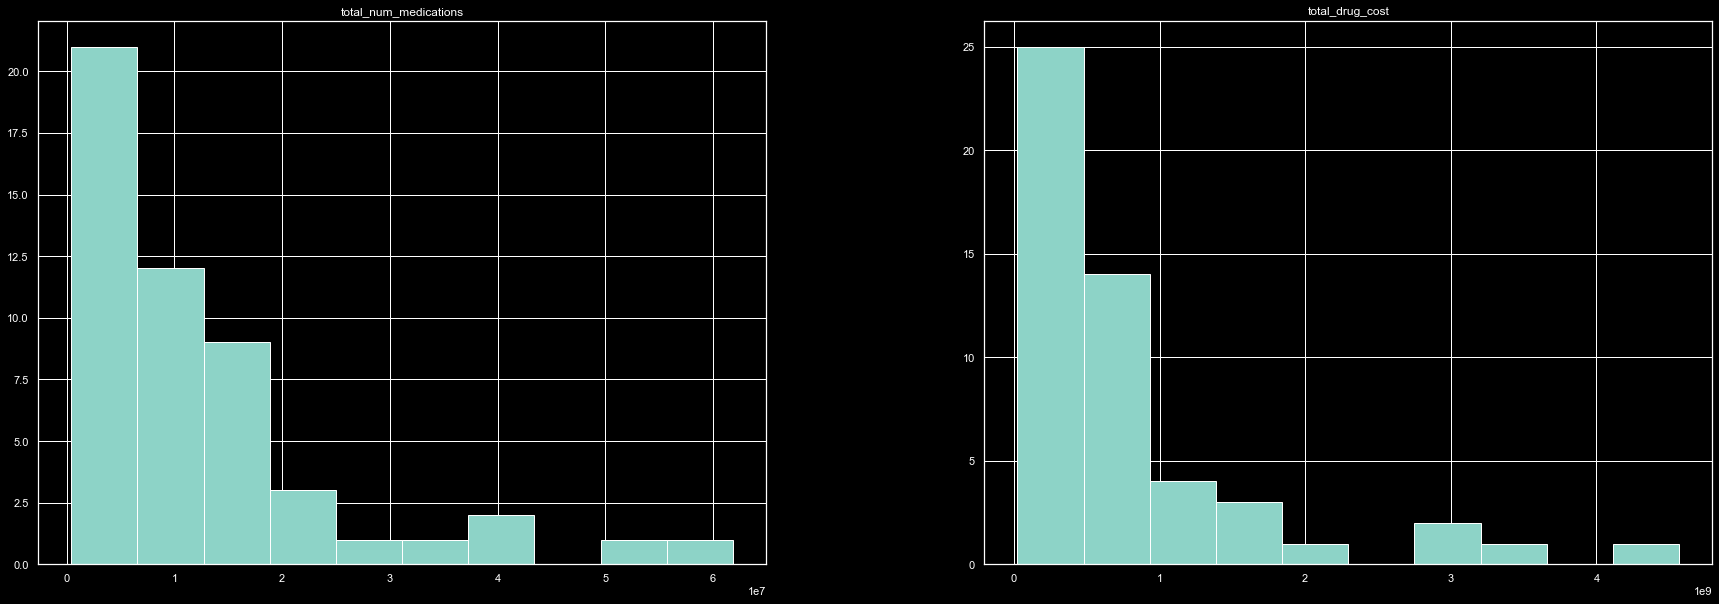

In [911]:
# Looking at the distribution of the data via a histogram
tot_meds_per_state.hist()

In [912]:
#  We expect that the total drug cost is correlated with the total number of prescriptions
tot_meds_per_state.corr()

,total_num_medications,total_drug_cost
total_num_medications,1.000000,0.986998
total_drug_cost,0.986998,1.000000


#### Most perscribed medication

##### SQL query: Most common per state

In [953]:
query = """ SELECT * FROM (SELECT nppes_provider_state as state, 
                                                  generic_name as medication_perscribed,
                                                  SUM(total_claim_count_ge65) as num_perscribed,
                                                   ROW_NUMBER() OVER (PARTITION BY nppes_provider_state 
                                                                                              ORDER BY SUM(total_claim_count_ge65) DESC) as rank 
                                                   FROM bigquery-public-data.medicare.part_d_prescriber_2014
                                                   WHERE (nppes_provider_state != 'AA' AND 
                                                                    nppes_provider_state != 'AE' AND 
                                                                    nppes_provider_state != 'AS' AND
                                                                    nppes_provider_state != 'AP' AND
                                                                    nppes_provider_state != 'GU' AND
                                                                    nppes_provider_state != 'MP' AND
                                                                    nppes_provider_state != 'PR' AND
                                                                    nppes_provider_state != 'VI' AND
                                                                    nppes_provider_state != 'XX' AND
                                                                    nppes_provider_state != 'ZZ')
                                                   GROUP BY 1, 2
                                                   ORDER BY 1, 3 DESC) as ranks
                   WHERE rank = 1;
              """

In [919]:
#  Process query
most_common_perscription = query_to_df(query)

#  Check results
print(len(most_common_perscription))
most_common_perscription.value_counts().head()

51


state  medication_perscribed  num_perscribed  rank
AK     LISINOPRIL             24329           1       1
PA     LEVOTHYROXINE SODIUM   1686883         1       1
ND     LEVOTHYROXINE SODIUM   84791           1       1
NE     LEVOTHYROXINE SODIUM   250443          1       1
NH     LEVOTHYROXINE SODIUM   96792           1       1
dtype: int64

##### Table: Top 5 most common by state ranking

In [1092]:
top_5_presc_us = most_common(most_common_perscription, 'num_perscribed', 5, 
                                                             groupby='medication_perscribed', counter=False)
top_5_presc_us

,medication_perscribed,num_perscribed
3,LEVOTHYROXINE SODIUM,20756951
0,AMLODIPINE BESYLATE,4139983
4,LISINOPRIL,3458573
2,HYDROCODONE/ACETAMINOPHEN,608744
1,ATORVASTATIN CALCIUM,477505


The top five prescriptions in the US to beneficiaries 65+:

- Levothyroxine sodium (~ 20.7M): used to treat hypothyroidism, enlarged thyroid glands, and thyroid cancer
- Amlodipine besylate (~ 4.1M): used to treat high blood pressure
- Lisinopril (~ 3.5M): treats high blood pressure and heart failure; can reduce risk of death after heart attack
- Hydrocodone/acetaminophen (e.g., vicodin; ~ 610k): narcotic used to treat pain 
- Atorvastatin calcium (~ 480k): slows cholesterol production in the body and reduce buildup in ateral walls; used to decrease LDL cholesterol and increase HDL cholesterol

##### Exploratory plots

In [924]:
fig = px.bar(most_common_perscription.sort_values('num_perscribed'), x='medication_perscribed',
                     labels={'medication_perscribed':'', 'count': 'Number of states',
                                    'num_perscribed': 'Number perscribed'}, 
                     color = 'num_perscribed',
                     title='Most commonly perscribed medications to beneficiaries 65+ (US, 2014)',
                     hover_data={'state': True, 'num_perscribed': True, 'rank':False}
                     ) #hover_data=['lifeExp', 'gdpPercap']
fig.show()

Most common prescriptions based on the total number of claims from beneficiaries 65+ in each state. This bar chart isn't the most effective way to display this data. Let's try a geographic map instead.

In [316]:
# def retrieve_token():
#     with open('mapbox_token.json', 'r') as file:
#             config = json.load(file)
#             return config['token']

In [1109]:
df = most_common_perscription
locations='state'
color='medication_perscribed'
hover_name='state'
title =  'Most commonly perscribed medication to beneficiaries 65+ (US, 2014)'
hover_data={'medication_perscribed': True, 'state': False, 'num_perscribed': True}

plot_most_common_by_state(df, locations, color, hover_name, title, fontsize=16, hover_data=hover_data)

Fig. 3: By using a choropleth, we can plot without needing to worry about missing latitude and longitude data. Notice that a geographic viz reveals regional insights in a way that the bar chart doesn't.

#### Inpatient + outpatient charges

##### Table schema

In [956]:
table_name = 'inpatient_charges_2014'
df = table_schema(table_name, num_results=5, view_schema=True)
df

[SchemaField('drg_definition', 'STRING', 'REQUIRED', 'The code and description identifying the MS-DRG. MS-DRGs are a classification system that groups similar clinical conditions (diagnoses) and the procedures furnished by the hospital during the stay', (), None), SchemaField('provider_id', 'INTEGER', 'REQUIRED', 'The CMS Certification Number (CCN) of the provider billing for outpatient hospital services', (), None), SchemaField('provider_name', 'STRING', 'NULLABLE', 'The name of the provider', (), None), SchemaField('provider_street_address', 'STRING', 'NULLABLE', 'The street address in which the provider is physically located', (), None), SchemaField('provider_city', 'STRING', 'NULLABLE', 'The city in which the provider is physically located', (), None), SchemaField('provider_state', 'STRING', 'NULLABLE', 'The state in which the provider is physically located', (), None), SchemaField('provider_zipcode', 'INTEGER', 'NULLABLE', 'The zip code in which the provider is physically located'

/Users/Isabel/opt/anaconda3/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1860: UserWarning:

Cannot use bqstorage_client if max_results is set, reverting to fetching data with the REST endpoint.



,drg_definition,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zipcode,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments
0,164 - MAJOR CHEST PROCEDURES W CC,20001,PROVIDENCE ALASKA MEDICAL CENTER,BOX 196604,ANCHORAGE,AK,99508,AK - Anchorage,11,181591.00000,32837.18182,31369.181820
1,981 - EXTENSIVE O.R. PROCEDURE UNRELATED TO PR...,20001,PROVIDENCE ALASKA MEDICAL CENTER,BOX 196604,ANCHORAGE,AK,99508,AK - Anchorage,15,278825.00000,67174.86667,62515.733330
2,481 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOIN...,20001,PROVIDENCE ALASKA MEDICAL CENTER,BOX 196604,ANCHORAGE,AK,99508,AK - Anchorage,27,83832.14815,19251.92593,16767.111110
3,331 - MAJOR SMALL & LARGE BOWEL PROCEDURES W/O...,20001,PROVIDENCE ALASKA MEDICAL CENTER,BOX 196604,ANCHORAGE,AK,99508,AK - Anchorage,13,55260.84615,16206.38462,11776.615380
4,872 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,20001,PROVIDENCE ALASKA MEDICAL CENTER,BOX 196604,ANCHORAGE,AK,99508,AK - Anchorage,71,48617.81690,12784.09859,9715.929577


In [957]:
table_name = 'outpatient_charges_2014'
df = table_schema(table_name, num_results=5, view_schema=True)
df

[SchemaField('apc', 'STRING', 'REQUIRED', 'Code and description identifying the APC. APCs are a classification system where individual services (Healthcare Common Procedure Coding System [HCPCS] codes) are assigned based on similar clinical characteristics and similar costs', (), None), SchemaField('provider_id', 'INTEGER', 'REQUIRED', 'The CMS Certification Number (CCN) of the provider billing for outpatient hospital services', (), None), SchemaField('provider_name', 'STRING', 'NULLABLE', 'The name of the provider', (), None), SchemaField('provider_street_address', 'STRING', 'NULLABLE', 'The street address in which the provider is physically located', (), None), SchemaField('provider_city', 'STRING', 'NULLABLE', 'The city in which the provider is physically located', (), None), SchemaField('provider_state', 'STRING', 'NULLABLE', 'The state in which the provider is physically located', (), None), SchemaField('provider_zipcode', 'INTEGER', 'NULLABLE', 'The zip code in which the provider

/Users/Isabel/opt/anaconda3/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1860: UserWarning:

Cannot use bqstorage_client if max_results is set, reverting to fetching data with the REST endpoint.



,apc,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zipcode,hospital_referral_region,outpatient_services,average_estimated_submitted_charges,average_total_payments
0,0013 - Level II Debridement & Destruction,20001,PROVIDENCE ALASKA MEDICAL CENTER,BOX 196604,ANCHORAGE,AK,99508,AK - Anchorage,232,308.596121,99.420302
1,0015 - Level III Debridement & Destruction,20001,PROVIDENCE ALASKA MEDICAL CENTER,BOX 196604,ANCHORAGE,AK,99508,AK - Anchorage,401,543.633915,172.057057
2,0078 - Level III Pulmonary Treatment,20001,PROVIDENCE ALASKA MEDICAL CENTER,BOX 196604,ANCHORAGE,AK,99508,AK - Anchorage,58,761.327586,155.961035
3,0204 - Level I Nerve Injections,20001,PROVIDENCE ALASKA MEDICAL CENTER,BOX 196604,ANCHORAGE,AK,99508,AK - Anchorage,17,1938.237059,234.320000
4,0206 - Level II Nerve Injections,20001,PROVIDENCE ALASKA MEDICAL CENTER,BOX 196604,ANCHORAGE,AK,99508,AK - Anchorage,19,2881.493684,422.650000


##### SQL query: Inpatient and outpatient totals

In [983]:
query = """SELECT inpatient_charges_2014.provider_state as state, 
                                 SUM(inpatient_charges_2014.total_discharges) as total_discharges,
                                 SUM(inpatient_charges_2014.average_total_payments) as inpatient_av_total_payments,
                                 SUM(outpatient_charges_2014.outpatient_services) as total_outpatient_servies,
                                 SUM(outpatient_charges_2014.average_total_payments) as outpatient_av_total_payments,
                  FROM bigquery-public-data.medicare.inpatient_charges_2014
                  JOIN bigquery-public-data.medicare.outpatient_charges_2014
                  ON inpatient_charges_2014.provider_id = outpatient_charges_2014.provider_id
                  WHERE (inpatient_charges_2014.provider_state != 'AA' AND 
                                 inpatient_charges_2014.provider_state != 'AE' AND 
                                 inpatient_charges_2014.provider_state != 'AS' AND
                                 inpatient_charges_2014.provider_state != 'AP' AND
                                 inpatient_charges_2014.provider_state != 'GU' AND
                                 inpatient_charges_2014.provider_state != 'MP' AND
                                 inpatient_charges_2014.provider_state != 'PR' AND
                                 inpatient_charges_2014.provider_state != 'VI' AND
                                 inpatient_charges_2014.provider_state != 'XX' AND
                                 inpatient_charges_2014.provider_state != 'ZZ')
                  GROUP BY 1
                  ORDER BY 1, 3, 5 DESC;
                """

In [984]:
#  Process query
total_patient_av_payments = query_to_df(query)

#  Check results
print(len(total_patient_av_payments))
total_patient_av_payments.value_counts().head()

50


state  total_discharges  inpatient_av_total_payments  total_outpatient_servies  outpatient_av_total_payments
AK     62346             5.098579e+07                 1496971                   7.397428e+05                    1
PA     5261656           2.107692e+09                 164344086                 4.930443e+07                    1
ND     441967            1.758384e+08                 51717947                  4.238517e+06                    1
NE     660416            2.703427e+08                 10786468                  6.759499e+06                    1
NH     650765            2.754683e+08                 56179904                  6.816988e+06                    1
dtype: int64

#### Inpatient data

##### Average total inpatient payments US

In [1158]:
query = """ SELECT provider_state as state,
                                 SUM(total_discharges) as total_discharges,
                                 SUM(average_total_payments) as average_total_payments
                   FROM bigquery-public-data.medicare.inpatient_charges_2014
                   GROUP BY 1;
              """

In [1159]:
#  Process query
total_inpatient_state_charges = query_to_df(query)

#  Check results
total_inpatient_state_charges

,state,f0_,average_total_payments
0,AK,6515,5.405866e+06
1,AL,152700,4.310311e+07
2,AR,89703,2.607595e+07
3,AZ,111269,4.772144e+07
4,CA,500440,2.627543e+08
5,CO,66216,3.009176e+07
6,CT,100251,3.831971e+07
7,DC,26278,1.371171e+07
8,DE,35510,1.005834e+07
9,FL,594009,1.744718e+08


In [1157]:
total_inpatient_charges = total_inpatient_state_charges['average_total_payments'].sum()
print('${0:,.2f}'.format(total_inpatient_charges))

$2,668,687,724.55


Total inpatient charges reached nearly $3 billion.

##### Map: State inpatient charges per 10,000 discharges

In [1163]:
total_inpatient_state_charges['inpatient_charges_per_10k_discharges'] = (total_inpatient_state_charges['average_total_payments'] / 
                                                                                                                                   total_inpatient_state_charges['f0_']) * 10000

In [1170]:
df = total_inpatient_state_charges
locations='state'
color='inpatient_charges_per_10k_discharges'
hover_name='state'
title =  'State inpatient cost per 10,000 discharges (US, 2014)'
hover_data={'inpatient_charges_per_10k_discharges': True, 'state': True}

plot_most_common_by_state(df, locations, color, hover_name, title, fontsize=12, hover_data=hover_data)

Fig. 4: Here we see a split roughly across the eastern and western states. Western states appear to have higher charges, with Alaska and Hawaii having the two highest rates.

##### SQL query: Most common MS-DRG by zip code

In [1133]:
query = """ SELECT * FROM (SELECT provider_state as state, 
                                                  provider_zipcode as zipcode,
                                                  drg_definition as ms_drg,
                                                  SUM(total_discharges) as total_discharges,
                                                  SUM(average_total_payments) as average_total_payments,
                                                  ROW_NUMBER() OVER (PARTITION BY provider_zipcode 
                                                                                              ORDER BY SUM(total_discharges) DESC) as rank 
                                                   FROM bigquery-public-data.medicare.inpatient_charges_2014
                                                   WHERE (provider_state != 'AA' AND 
                                                                   provider_state != 'AE' AND 
                                                                   provider_state != 'AS' AND
                                                                   provider_state != 'AP' AND
                                                                   provider_state != 'GU' AND
                                                                   provider_state != 'MP' AND
                                                                   provider_state != 'PR' AND
                                                                   provider_state != 'VI' AND
                                                                   provider_state != 'XX' AND
                                                                   provider_state != 'ZZ')
                                                   GROUP BY 1, 2, 3
                                                   ORDER BY 1, 4 DESC) as ranks
                   WHERE rank = 1
              """

In [1134]:
#  Process query
most_common_ms_drg = query_to_df(query)

#  Check results
print(len(most_common_ms_drg))

most_common_ms_drg.value_counts().head()

2987


state  zipcode  ms_drg                                                                    total_discharges  average_total_payments  rank
AK     99508    470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC  612               64628.432720            1       1
OH     44109    871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC                  142               20052.049300            1       1
       43952    871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC                  118               10431.889830            1       1
       44004    190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC                         73                7640.465753             1       1
       44024    871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC                  149               10221.758390            1       1
dtype: int64

##### Top 5 in the US

In [1091]:
top_5_ms_drg_us = most_common(most_common_ms_drg, 'total_discharges', 5, groupby='ms_drg', counter=False)
top_5_ms_drg_us

,ms_drg,total_discharges
29,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,297894
43,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,249226
46,885 - PSYCHOSES,47000
26,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",7817
13,194 - SIMPLE PNEUMONIA & PLEURISY W CC,6388


The 5 most common MS-DRGs in the US (in terms of total discharges) are: 
- 470: Major joint replacement or reattachment of lower extremity (297,894) 
- 871: Septicemia or severe sepsis (249,226)
- 885: Psychoses (47,000)
- 392: Esophagitits & gastro/digestion disorders (7,817) 
- 194: Simple pneumonia & pleurisy (6,388)

We can see that theres about an order of magnitude difference between (1)/(2) and (3) as well as between (3) and (4). 

##### Most common by state

In [1135]:
#  Aggregate data by state, summing total discharges for each MS-DRG
temp_df = most_common_ms_drg.groupby(['state', 'ms_drg'])[['total_discharges', 'average_total_payments']].sum()
#  Reset index to flatten df
temp_df = temp_df.reset_index()
temp_df.head()

,state,ms_drg,total_discharges,average_total_payments
0,AK,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,725,103106.012130
1,AK,603 - CELLULITIS W/O MCC,22,15553.863640
2,AK,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,65,19795.246150
3,AK,885 - PSYCHOSES,81,15896.987650
4,AL,101 - SEIZURES W/O MCC,29,8785.689655


In [1136]:
temp_df['rank_by_ms_drg'] = temp_df.groupby('state')['total_discharges'].rank(ascending=False)
temp_df = temp_df.reset_index()
temp_df.head()

,index,state,ms_drg,total_discharges,average_total_payments,rank_by_ms_drg
0,0,AK,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,725,103106.012130,1.0
1,1,AK,603 - CELLULITIS W/O MCC,22,15553.863640,4.0
2,2,AK,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,65,19795.246150,3.0
3,3,AK,885 - PSYCHOSES,81,15896.987650,2.0
4,4,AL,101 - SEIZURES W/O MCC,29,8785.689655,13.0


In [1140]:
most_common_state_ms_drg = temp_df.loc[temp_df['rank_by_ms_drg'] == 1.0]
most_common_state_ms_drg

,index,state,ms_drg,total_discharges,average_total_payments,rank_by_ms_drg
0,0,AK,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,725,1.031060e+05,1.0
11,11,AL,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,7235,2.855679e+05,1.0
27,27,AR,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,3491,1.386440e+05,1.0
36,36,AZ,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,8419,4.234054e+05,1.0
53,53,CA,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,33592,3.089695e+06,1.0
60,60,CO,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,6499,4.895257e+05,1.0
65,65,CT,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,5112,3.062204e+05,1.0
69,69,DC,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,838,3.440614e+04,1.0
72,72,DE,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,1745,2.991321e+04,1.0
81,81,FL,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,20719,8.710640e+05,1.0


While the US has a top N, there are two codes (470 and 871) that clearly dominate. 

In [1141]:
#  Getting a count of states 
df = most_common_state_ms_drg
category = 'ms_drg'
N = 2
most_common(df, category, N, groupby=None, counter=True)

{'470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC': 35, '871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC': 16}


Nearly 70% of US states (including DC) have Code 470 as the top most common MS-DRG. Next we'll map this geographically to see if there are any regional trends.

##### Map: Most common by state

In [1142]:
df = most_common_state_ms_drg
locations='state'
color='ms_drg'
hover_name='state'
title =  'Most common MS-DRG per state (US, 2014)'
hover_data={'ms_drg': True, 'state': True, 'total_discharges': True, 'average_total_payments': True}

plot_most_common_by_state(df, locations, color, hover_name, title, fontsize=9, hover_data=hover_data)

Fig. 5: The majority of western and midwestern states have 470 as the most common inpatient MS-DRG code, while about half of southeastern states and the majority of mid-Atlantic states have 871.

#### Outpatient data

##### Average total outpatient payments US

In [1165]:
query = """ SELECT provider_state as state,
                                 SUM(outpatient_services) as outpatient_services,
                                 SUM(average_total_payments) as average_total_payments
                   FROM bigquery-public-data.medicare.outpatient_charges_2014
                   GROUP BY 1;
              """

In [1166]:
#  Process query
total_outpatient_state_charges = query_to_df(query)

#  Check results
total_outpatient_state_charges

,state,outpatient_services,average_total_payments
0,AK,27291,1.828298e+04
1,AL,286564,2.115875e+05
2,AR,442708,1.448559e+05
3,AZ,273667,1.803323e+05
4,CA,2011387,1.005932e+06
5,CO,365214,1.646786e+05
6,CT,415742,1.705221e+05
7,DC,110741,3.778744e+04
8,DE,147165,2.589969e+04
9,FL,1178232,5.608929e+05


In [1153]:
total_outpatient_charges = total_outpatient_state_charges['average_total_payments'].sum()
print('${0:,.2f}'.format(total_outpatient_charges))

$12,109,334.59


Outpatient charges exceeded $12 million.

##### Map: State inpatient charges per 1k outpatient services

In [1167]:
total_outpatient_state_charges['outpatient_charges_per_1k_discharges'] = (total_outpatient_state_charges['average_total_payments'] / 
                                                                                                                                   total_outpatient_state_charges['outpatient_services']) * 1000

In [1171]:
df = total_outpatient_state_charges
locations='state'
color='outpatient_charges_per_1k_discharges'
hover_name='state'
title =  'State outpatient cost per 1k outpatient services (US, 2014)'
hover_data={'outpatient_charges_per_1k_discharges': True, 'state': True}

plot_most_common_by_state(df, locations, color, hover_name, title, fontsize=12, hover_data=hover_data)

Fig. 6: Where Alaska was the outlier for inpatient charges, Wyoming is the outlier for outpatient service charges.

##### SQL query: Most common APC by zip code

In [1143]:
query = """ SELECT * FROM (SELECT provider_state as state, 
                                                  provider_zipcode as zipcode,
                                                  apc as apc,
                                                  SUM(outpatient_services) as total_outpatient_services,
                                                  SUM(average_total_payments) as average_total_payments,
                                                  ROW_NUMBER() OVER (PARTITION BY provider_zipcode 
                                                                                              ORDER BY SUM(outpatient_services) DESC) as rank 
                                                   FROM bigquery-public-data.medicare.outpatient_charges_2014
                                                   WHERE (provider_state != 'AA' AND 
                                                                   provider_state != 'AE' AND 
                                                                   provider_state != 'AS' AND
                                                                   provider_state != 'AP' AND
                                                                   provider_state != 'GU' AND
                                                                   provider_state != 'MP' AND
                                                                   provider_state != 'PR' AND
                                                                   provider_state != 'VI' AND
                                                                   provider_state != 'XX' AND
                                                                   provider_state != 'ZZ')
                                                   GROUP BY 1, 2, 3
                                                   ORDER BY 1, 4 DESC) as ranks
                   WHERE rank = 1
              """

In [1144]:
#  Process query
most_common_apc = query_to_df(query)

#  Check results
print(len(most_common_apc))
most_common_apc.value_counts().head()

2806


state  zipcode  apc                            total_outpatient_services  average_total_payments  rank
AK     99508    0634 - Hospital Clinic Visits  8739                       220.672185              1       1
OH     44307    0634 - Hospital Clinic Visits  5456                       85.389500               1       1
       44143    0634 - Hospital Clinic Visits  3139                       87.061682               1       1
       44145    0634 - Hospital Clinic Visits  1541                       86.393303               1       1
       44195    0634 - Hospital Clinic Visits  358931                     86.682060               1       1
dtype: int64

##### Top 5 APC in the US

In [1146]:
top_5_apc_us = most_common(most_common_apc, 'total_outpatient_services', 5, groupby='apc', counter=False)
top_5_apc_us

,apc,total_outpatient_services
13,0634 - Hospital Clinic Visits,22651720
7,0269 - Level II Echocardiogram Without Contrast,260307
8,0336 - Magnetic Resonance Imaging and Magnetic...,100223
4,0207 - Level III Nerve Injections,75810
6,0267 - Level III Diagnostic and Screening Ultr...,64962


The 5 most common APCs in the US (in terms of total outpatient services) are: 
- 0634: Hospital Clinic Visits (~ 23M) 
- 0269: L2 Echocardiogram w/o contrast (~ 260k)
- 0336: MRI (~ 100k)
- 0207: L3 Nerve injections (~ 76k) 
- 0267: L3 Diagnostic and screening ultrasounds (~ 65k)

Given that hospital clinic visits is more than three orders of magitudes larger than the next four combined, we expect that this would be the single most common APC in each state.

##### Most common APC by state

In [1148]:
#  Aggregate data by state, summing total discharges for each MS-DRG
temp_df_apc = most_common_apc.groupby(['state', 'apc'])[['total_outpatient_services', 'average_total_payments']].sum()
#  Reset index to flatten df
temp_df_apc = temp_df_apc.reset_index()
temp_df_apc.head()

,state,apc,total_outpatient_services,average_total_payments
0,AK,0634 - Hospital Clinic Visits,17935,676.677802
1,AL,0015 - Level III Debridement & Destruction,2195,252.064553
2,AL,0207 - Level III Nerve Injections,5438,2763.603221
3,AL,0265 - Level I Diagnostic and Screening Ultras...,145,73.310483
4,AL,0267 - Level III Diagnostic and Screening Ultr...,2043,2254.117451


In [1154]:
temp_df_apc['rank_by_apc'] = temp_df_apc.groupby('state')[['total_outpatient_services']].rank(ascending=False)
temp_df_apc = temp_df_apc.reset_index()
temp_df_apc.head()

,index,state,apc,total_outpatient_services,average_total_payments,rank_by_apc
0,0,AK,0634 - Hospital Clinic Visits,17935,676.677802,1.0
1,1,AL,0015 - Level III Debridement & Destruction,2195,252.064553,5.0
2,2,AL,0207 - Level III Nerve Injections,5438,2763.603221,4.0
3,3,AL,0265 - Level I Diagnostic and Screening Ultras...,145,73.310483,7.0
4,4,AL,0267 - Level III Diagnostic and Screening Ultr...,2043,2254.117451,6.0


In [1130]:
most_common_state_apc = temp_df_apc.loc[temp_df_apc['rank_by_apc'] == 1.0]
most_common_state_apc

,index,state,apc,total_outpatient_services,rank_by_apc
0,0,AK,0634 - Hospital Clinic Visits,17935,1.0
7,7,AL,0634 - Hospital Clinic Visits,125011,1.0
13,13,AR,0634 - Hospital Clinic Visits,280430,1.0
21,21,AZ,0634 - Hospital Clinic Visits,172605,1.0
30,30,CA,0634 - Hospital Clinic Visits,1458274,1.0
37,37,CO,0634 - Hospital Clinic Visits,241086,1.0
43,43,CT,0634 - Hospital Clinic Visits,281677,1.0
45,45,DC,0634 - Hospital Clinic Visits,88160,1.0
46,46,DE,0634 - Hospital Clinic Visits,106688,1.0
52,52,FL,0634 - Hospital Clinic Visits,766486,1.0


And this is actually the case!

In [1132]:
#  Getting a count of states 
df = most_common_state_apc
category = 'apc'
N = 2
most_common(df, category, N, groupby=None, counter=True)

{'0634 - Hospital Clinic Visits': 50}


## Merge state datasets

### State population over 65 (est., 2014)

#### Looking at data

In [635]:
# Pull in state population by age group data
pop_alldata_2014 = pd.read_csv("../data/input/csv/sc-est2019-alldata6.csv", usecols=[ "NAME", "AGE", "SEX", 
                                                                                                                                                 "RACE", "ORIGIN", "POPESTIMATE2014"])
pop_alldata_2014.head()

,NAME,SEX,ORIGIN,RACE,AGE,POPESTIMATE2014
0,Alabama,0,0,1,0,37575
1,Alabama,0,0,1,1,36968
2,Alabama,0,0,1,2,37769
3,Alabama,0,0,1,3,38605
4,Alabama,0,0,1,4,37751


In [636]:
pop_alldata_2014.tail()

,NAME,SEX,ORIGIN,RACE,AGE,POPESTIMATE2014
236839,Wyoming,2,2,6,81,2
236840,Wyoming,2,2,6,82,1
236841,Wyoming,2,2,6,83,2
236842,Wyoming,2,2,6,84,1
236843,Wyoming,2,2,6,85,3


AGE is single-year of age (0, 1, 2,… 84, 85+ years)

The key for SEX is as follows:
- 0 = Total
- 1 = Male
- 2 = Female

The key for ORIGIN is as follows:
- 0 = Total
- 1 = Not Hispanic
- 2 = Hispanic

The key for RACE is as follows:
- 1 = White Alone
- 2 = Black or African American Alone
- 3 = American Indian or Alaska Native Alone
- 4 = Asian Alone
- 5 = Native Hawaiian and Other Pacific Islander Alone
- 6 = Two or more races

We want (per state ages 65+): 1) total pop 2) percentages by gender 4) percent hisp 6) percentages by race

In [637]:
print(len(pop_alldata_2014))

236844


#### Define helper calculation functions

In [714]:
def sum_data(df, where_category, value, column):
    return df.where(df[where_category] == value)[column].sum()

def calc_percent(df, category1, category2, state, val1, val2, column, use_sum=False):
    if use_sum:
            partial_sum =  df.where((df[category1] == state) & 
                                                (df[category2] == val1))[column].sum()
            total_sum = val2
    else:
        partial_sum =  df.where((df[category1] == state) & 
                                                    (df[category2] == val1))[column].sum() 
        total_sum = df.where((df[category1] == state) & 
                                                    (df[category2] == val2))[column].sum()
    percent = (partial_sum / total_sum) * 100
    return percent

#### Defining useful dictionaries

In [640]:
# Source: A Python Dictionary to translate US States to Two letter codes (https://gist.github.com/rogerallen/1583593)
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'United States': 'US',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

In [709]:
data_key = {'total gender': 0.0, 
                     'm': 1.0, 'f': 2.0, 
                     'hisp': 1.0, 'white': 1.0, 
                     'black': 2.0, 'nam': 3.0, 
                      'asian': 4.0, 'nhi pi': 5.0, 
                      '2+': 6.0}

#### Pull and format data

In [638]:
# Want all ages over 65, but don't want to include 999 (which likley means 'unknown')
pop_alldata_over_65_2014 = pop_alldata_2014[ (pop_alldata_2014["AGE"] >= 65) &  (pop_alldata_2014["AGE"] < 999)] 

In [1189]:
#  Want demographics in terms of percent of folks over 65, and population sums for each state
my_dict = {}
for key, val in abbrev_us_state.items():
    state_pop = sum_data(pop_alldata_over_65_2014, 'NAME', val,  'POPESTIMATE2014')
    my_dict[val] = {"State": key, 
                                'Population over 65': state_pop,
                                'Male (%)': calc_percent(pop_alldata_over_65_2014, 'NAME', 'SEX', val, data_key['m'], 
                                                                           data_key['total gender'], 'POPESTIMATE2014'),
                                'Female (%)': calc_percent(pop_alldata_over_65_2014, 'NAME', 'SEX', val, data_key['f'], 
                                                                           data_key['total gender'], 'POPESTIMATE2014'),
                                'White (%)': calc_percent(pop_alldata_over_65_2014, 'NAME', 'RACE', val, data_key['white'], 
                                                                           state_pop, 'POPESTIMATE2014', use_sum=True),
                                'Black (%)': calc_percent(pop_alldata_over_65_2014, 'NAME', 'RACE', val, data_key['black'], 
                                                                           state_pop, 'POPESTIMATE2014', use_sum=True),
                                'Native American (%)': calc_percent(pop_alldata_over_65_2014, 'NAME', 'RACE', val, 
                                                                            data_key['nam'], state_pop, 'POPESTIMATE2014', use_sum=True),
                                'Asian (%)': calc_percent(pop_alldata_over_65_2014, 'NAME', 'RACE', val, 
                                                                            data_key['asian'], state_pop, 'POPESTIMATE2014', use_sum=True),
                                'Native Hawaiian and Pacific Islander (%)': calc_percent(pop_alldata_over_65_2014, 'NAME', 'RACE', val, 
                                                                            data_key['nhi pi'], state_pop, 'POPESTIMATE2014', use_sum=True),
                                'Two or More Races (%)': calc_percent(pop_alldata_over_65_2014, 'NAME', 'RACE', val, 
                                                                            data_key['2+'], state_pop, 'POPESTIMATE2014', use_sum=True),
                                'Hispanic (%)': calc_percent(pop_alldata_over_65_2014, 'NAME', 'ORIGIN', val, 
                                                                            data_key['hisp'], state_pop, 'POPESTIMATE2014', use_sum=True)
                                }

<ipython-input-714-46509bf6a8f4>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-714-46509bf6a8f4>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-714-46509bf6a8f4>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-714-46509bf6a8f4>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-714-46509bf6a8f4>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-714-46509bf6a8f4>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-714-46509bf6a8f4>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-714-46509bf6a8f4>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-714-46509bf6a8f4>:14: RuntimeWarning:

invalid value encountered in double_scalars



In [1190]:
state_data_over_65_2014 = pd.DataFrame.from_dict(my_dict, orient='index')
state_data_over_65_2014.head()

,State,Population over 65,Male (%),Female (%),White (%),Black (%),Native American (%),Asian (%),Native Hawaiian and Pacific Islander (%),Two or More Races (%),Hispanic (%)
Alabama,AL,2967264.0,43.217860,56.782140,79.907147,18.243877,0.475050,0.655958,0.025478,0.692490,49.528657
Alaska,AK,279576.0,49.587947,50.412053,76.867828,2.057401,12.408790,5.923255,0.437806,2.304919,48.770281
Arizona,AZ,4239816.0,46.086245,53.913755,92.575999,2.212926,2.428879,1.953575,0.096891,0.731730,44.125594
Arkansas,AR,1862060.0,44.251420,55.748580,88.554826,9.309260,0.558951,0.630914,0.038452,0.907597,49.319786
California,CA,19803224.0,44.155315,55.844685,77.230576,5.423359,0.933000,14.692052,0.295326,1.425687,40.602924


#### Compiling medicare and population data

In [1200]:
#  Merge in/outpatient data with prescription totals
compiled_df = pd.merge(total_patient_av_payments, total_prescription_state, on="state")
compiled_df.head()

,state,total_discharges,inpatient_av_total_payments,total_outpatient_servies,outpatient_av_total_payments,num_prescribed,total_drug_cost
0,AK,62346,5.098579e+07,1496971,7.397428e+05,428694,2.432429e+07
1,AL,1780806,5.357359e+08,43108168,1.660494e+07,14067221,7.515726e+08
2,AR,1312795,3.954642e+08,50587464,1.120277e+07,8452560,3.899176e+08
3,AZ,1263027,5.776273e+08,25075217,1.485696e+07,9845726,6.781368e+08
4,CA,6171333,3.575782e+09,251614007,8.115323e+07,61833844,4.568203e+09


In [1201]:
#  Merge with most commonly prescribed data
compiled_df = pd.merge(compiled_df, most_common_perscription, on='state')
compiled_df.head()

,state,total_discharges,inpatient_av_total_payments,total_outpatient_servies,outpatient_av_total_payments,num_prescribed,total_drug_cost,medication_perscribed,num_perscribed,rank
0,AK,62346,5.098579e+07,1496971,7.397428e+05,428694,2.432429e+07,LISINOPRIL,24329,1
1,AL,1780806,5.357359e+08,43108168,1.660494e+07,14067221,7.515726e+08,HYDROCODONE/ACETAMINOPHEN,608744,1
2,AR,1312795,3.954642e+08,50587464,1.120277e+07,8452560,3.899176e+08,LEVOTHYROXINE SODIUM,363817,1
3,AZ,1263027,5.776273e+08,25075217,1.485696e+07,9845726,6.781368e+08,LEVOTHYROXINE SODIUM,611295,1
4,CA,6171333,3.575782e+09,251614007,8.115323e+07,61833844,4.568203e+09,LEVOTHYROXINE SODIUM,2542561,1


In [1202]:
#  Renaming columns, will eventually drop 'rank'
compiled_df.columns = ['State', 
                                            'Total discharges', 
                                            'Inpatient total payments (avg)', 
                                            'Total outpatient services', 
                                            'Outpatient total payments (avg)', 
                                            'Total prescriptions 65+ (Medicare D)', 
                                            'Total drug cost 65+',
                                            'Top prescription',
                                            'Number of prescriptions',
                                            'rank']

In [1203]:
compiled_df['Percent of total prescriptions']=(compiled_df["Number of prescriptions"] / 
                                                                                 compiled_df["Total prescriptions 65+ (Medicare D)"]) * 100

In [1204]:
compiled_df = pd.merge(state_data_over_65_2014[['State', 'Population over 65']], compiled_df, on='State')
compiled_df.head()

,State,Population over 65,Total discharges,Inpatient total payments (avg),Total outpatient services,Outpatient total payments (avg),Total prescriptions 65+ (Medicare D),Total drug cost 65+,Top prescription,Number of prescriptions,rank,Percent of total prescriptions
0,AL,2967264.0,1780806,5.357359e+08,43108168,1.660494e+07,14067221,7.515726e+08,HYDROCODONE/ACETAMINOPHEN,608744,1,4.327393
1,AK,279576.0,62346,5.098579e+07,1496971,7.397428e+05,428694,2.432429e+07,LISINOPRIL,24329,1,5.675144
2,AZ,4239816.0,1263027,5.776273e+08,25075217,1.485696e+07,9845726,6.781368e+08,LEVOTHYROXINE SODIUM,611295,1,6.208735
3,AR,1862060.0,1312795,3.954642e+08,50587464,1.120277e+07,8452560,3.899176e+08,LEVOTHYROXINE SODIUM,363817,1,4.304223
4,CA,19803224.0,6171333,3.575782e+09,251614007,8.115323e+07,61833844,4.568203e+09,LEVOTHYROXINE SODIUM,2542561,1,4.111925


In [1207]:
#  Per capita normalizes data so that it's not skewed by state population size
compiled_df['Total perscriptions per 100k'] = (compiled_df['Total prescriptions 65+ (Medicare D)'] / 
                                                                                 compiled_df['Population over 65']) * 100000

In [1206]:
np.round(compiled_df['Percent of total prescriptions'].mean(), 2)

5.16

Table: When we look at what percentage the most commonly perscribed medication is compared to the total number of perscriptions, we get an average value of ~5.2%, i.e., it makes up a small piece of the prescription pie.

In [1213]:
# Dropping rank column
compiled_df = compiled_df.drop(columns=['rank'])

In [1223]:
#  Shifting per capita column and finalizing variable name
state_med_pop_data = compiled_df[['State',
                                                                  'Population over 65',
                                                                  'Total discharges', 
                                                                  'Inpatient total payments (avg)', 
                                                                  'Total outpatient services', 
                                                                  'Outpatient total payments (avg)', 
                                                                  'Total prescriptions 65+ (Medicare D)', 
                                                                  'Total perscriptions per 100k', 
                                                                  'Total drug cost 65+',
                                                                  'Top prescription',
                                                                  'Number of prescriptions',
                                                                  'Percent of total prescriptions']]
state_med_pop_data.head()

,State,Population over 65,Total discharges,Inpatient total payments (avg),Total outpatient services,Outpatient total payments (avg),Total prescriptions 65+ (Medicare D),Total perscriptions per 100k,Total drug cost 65+,Top prescription,Number of prescriptions,Percent of total prescriptions
0,AL,2967264.0,1780806,5.357359e+08,43108168,1.660494e+07,14067221,474080.533448,7.515726e+08,HYDROCODONE/ACETAMINOPHEN,608744,4.327393
1,AK,279576.0,62346,5.098579e+07,1496971,7.397428e+05,428694,153337.196326,2.432429e+07,LISINOPRIL,24329,5.675144
2,AZ,4239816.0,1263027,5.776273e+08,25075217,1.485696e+07,9845726,232220.596366,6.781368e+08,LEVOTHYROXINE SODIUM,611295,6.208735
3,AR,1862060.0,1312795,3.954642e+08,50587464,1.120277e+07,8452560,453935.963395,3.899176e+08,LEVOTHYROXINE SODIUM,363817,4.304223
4,CA,19803224.0,6171333,3.575782e+09,251614007,8.115323e+07,61833844,312241.299699,4.568203e+09,LEVOTHYROXINE SODIUM,2542561,4.111925


#### Plot: Number of perscriptions per capita (over 65)

In [1225]:
df = state_med_pop_data
x = 'State'
y = 'Total perscriptions per 100k'
fig = px.bar(df.sort_values(y), 
                     x=x, y=y, 
                     labels={x: 'State', y: ''}, 
                     title='Number of perscriptions per 100,000 over 65 (US, 2014)',
                     color = 'Population over 65')
fig.show()

Fig. 6: Above figure is per 1000 people over the age of 65. Notice that in this case, Alaska ranks the lowest but Kentuky ranks the highest. The top 5 states with the most perscriptions per capita over 65 (KY, MS, LA, RI, AL) have elderly populations below 3M while bottom 5 states (AK, WY, DC, NH, HI) have elderly populations under 1M. Note that use of a heat map is helpful for exploratory purposes. Actually, top 10-ish sates are largely southern and midwestern while the bottom 10-ish are largely western and mid-atlantic states. Some of the things we could consider in an explanitory analysis is how these states differ in terms of gender, income and poverty rates, and race.

### Poverty and median household income data (2014)

In [1226]:
#  Renaming state column to match poverty dataset for merge, and fixing typo
state_med_pop_data = state_med_pop_data.rename(columns={'State':'Postal Code', 
                                                                                                                  'Total perscriptions per 100k': 'Total prescriptions per 100k'})

In [1228]:
poverty_data = pd.read_csv("../data/input/csv/est14us.csv", usecols=['Postal Code', 'Poverty Percent, All Ages', 
                                                                                                                   'Median Household Income'])

In [1229]:
state_med_estpop_income = pd.merge(state_med_pop_data, poverty_data, on='Postal Code')
state_med_estpop_income.head()

,Postal Code,Population over 65,Total discharges,Inpatient total payments (avg),Total outpatient services,Outpatient total payments (avg),Total prescriptions 65+ (Medicare D),Total prescriptions per 100k,Total drug cost 65+,Top prescription,Number of prescriptions,Percent of total prescriptions,"Poverty Percent, All Ages",Median Household Income
0,AL,2967264.0,1780806,5.357359e+08,43108168,1.660494e+07,14067221,474080.533448,7.515726e+08,HYDROCODONE/ACETAMINOPHEN,608744,4.327393,19.2,42917.0
1,AK,279576.0,62346,5.098579e+07,1496971,7.397428e+05,428694,153337.196326,2.432429e+07,LISINOPRIL,24329,5.675144,11.4,70898.0
2,AZ,4239816.0,1263027,5.776273e+08,25075217,1.485696e+07,9845726,232220.596366,6.781368e+08,LEVOTHYROXINE SODIUM,611295,6.208735,18.2,50036.0
3,AR,1862060.0,1312795,3.954642e+08,50587464,1.120277e+07,8452560,453935.963395,3.899176e+08,LEVOTHYROXINE SODIUM,363817,4.304223,18.7,41335.0
4,CA,19803224.0,6171333,3.575782e+09,251614007,8.115323e+07,61833844,312241.299699,4.568203e+09,LEVOTHYROXINE SODIUM,2542561,4.111925,16.4,61927.0


#### Map: Poverty rate

In [1240]:
df = state_med_estpop_income
locations = 'Postal Code'
color = 'Poverty Percent, All Ages'
hover_name = 'Postal Code'
title = 'Poverty Rate (All ages, 2014)'
fontsize= 12
plot_most_common_by_state(df, locations, color, hover_name, title, fontsize, hover_data=None)

Fig. 7: The lowest poverty rates appaer to be concentrated in southern states.

### Incorporating shape files

To create bivariate maps using Tableau, we'll add the shapefile information for each state.
To learn more about how to create bivariate maps, check out this article: https://www.tableau.com/about/blog/2018/2/how-make-effective-bivariate-choropleth-maps-tableau-83121

In [847]:
states = gpd.read_file('../data/input/cb_2014_us_state_5m/cb_2014_us_state_5m.shp')
states = states.rename(columns={"STUSPS": "Postal Code"})

In [1230]:
state_med_estpop_income_gdf = pd.merge(state_med_estpop_income, states, on="Postal Code")

## Saving datasets to csv

In [1241]:
#  State Medicare, population, and income data w/ state geometry data
state_med_estpop_income_gdf.to_csv('../data/output/state_med_estpop_income_geo_2014.csv', header=True)

In [1242]:
#  State population and demographics 
state_data_over_65_2014.to_csv('../data/output/state_data_over_65_2014.csv', header=True)

## Statistical analysis

#### Histograms (all data)

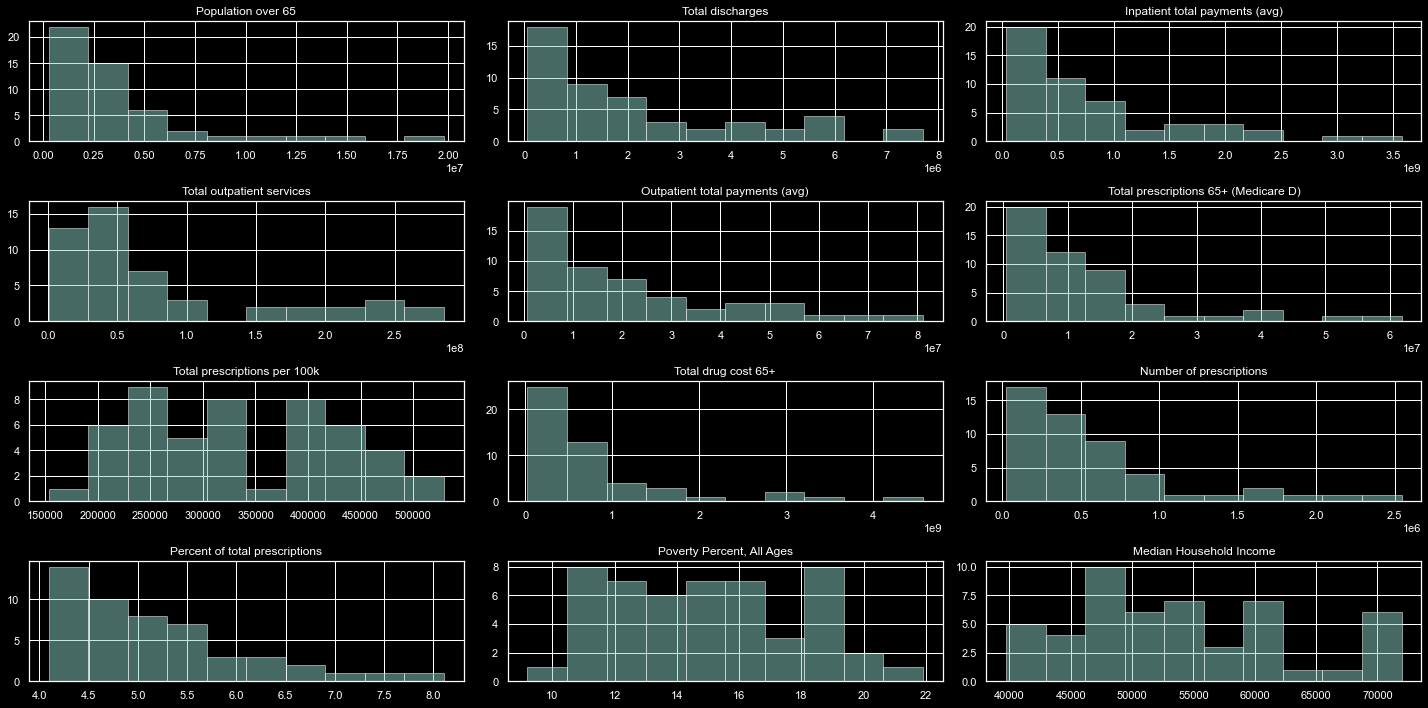

In [1233]:
#  Right click image to open in a new tab
state_med_estpop_income.hist(alpha=0.5, figsize=(20, 10))
plt.tight_layout()
plt.show()

#### Correlations (all data)

In [1234]:
state_med_estpop_income.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap("cool"), axis=1)

,Population over 65,Total discharges,Inpatient total payments (avg),Total outpatient services,Outpatient total payments (avg),Total prescriptions 65+ (Medicare D),Total prescriptions per 100k,Total drug cost 65+,Number of prescriptions,Percent of total prescriptions,"Poverty Percent, All Ages",Median Household Income
Population over 65,1.0,0.9,0.94,0.75,0.94,0.98,0.12,0.98,0.98,-0.45,0.19,0.0079
Total discharges,0.9,1.0,0.96,0.88,0.98,0.91,0.22,0.9,0.92,-0.55,0.15,-0.0066
Inpatient total payments (avg),0.94,0.96,1.0,0.88,0.99,0.94,0.15,0.95,0.94,-0.49,0.11,0.087
Total outpatient services,0.75,0.88,0.88,1.0,0.88,0.74,0.11,0.73,0.76,-0.4,0.012,0.098
Outpatient total payments (avg),0.94,0.98,0.99,0.88,1.0,0.94,0.18,0.94,0.94,-0.52,0.12,0.065
Total prescriptions 65+ (Medicare D),0.98,0.91,0.94,0.74,0.94,1.0,0.27,0.99,0.99,-0.52,0.27,-0.093
Total prescriptions per 100k,0.12,0.22,0.15,0.11,0.18,0.27,1.0,0.19,0.25,-0.56,0.51,-0.61
Total drug cost 65+,0.98,0.9,0.95,0.73,0.94,0.99,0.19,1.0,0.98,-0.49,0.21,-0.0072
Number of prescriptions,0.98,0.92,0.94,0.76,0.94,0.99,0.25,0.98,1.0,-0.47,0.26,-0.094
Percent of total prescriptions,-0.45,-0.55,-0.49,-0.4,-0.52,-0.52,-0.56,-0.49,-0.47,1.0,-0.25,0.15


#### Bivariate correlations w/ p-value

In [1238]:
fig = px.scatter(x=state_med_estpop_income['Total prescriptions 65+ (Medicare D)'], 
                            y=state_med_pop_data['Population over 65'],
                            title='Total prescriptions vs. Population over 65')
fig.show()

In [1236]:
#  returns correlation, p-value
# r=1 implies a strong, positive relationship
# r=0 implies no correlation
# r=-1 implies strong, negative relationship
x = state_med_estpop_income['Total prescriptions 65+ (Medicare D)']
y = state_med_pop_data['Population over 65']
r, p_value = stats.pearsonr(x, y)
print(np.round(r, 4))
print(np.round(p_value, 36))

0.9814
5.000000000000001e-36


With a correlation of 0.98 and a p-value of 5e-36, we can say that Fig.1 indeed implied a correlation between population and total number of perscriptions. This is why a per capita approach was needed.

## Tangents

#### Slices of the prescription pie

We'll look at the total number of prescriptions for the states with the highest (KY) and lowest (AK) per capita rate.

In [1251]:
query = """ SELECT nppes_provider_state as state,
                   generic_name as medication_perscribed,
                   SUM(total_claim_count_ge65) as total_num_medications,
                   SUM(total_drug_cost_ge65) as total_drug_cost
                    FROM bigquery-public-data.medicare.part_d_prescriber_2014
                    WHERE nppes_provider_state in ('AK', 'KY')
                    GROUP BY 1, 2
                    ORDER BY 1
              """

In [1252]:
#  Process query
prescriptions_ak_ky = query_to_df(query)

#  Check results
prescriptions_ak_ky.value_counts().head()

state  medication_perscribed  total_num_medications  total_drug_cost
AK     0.9 % SODIUM CHLORIDE  0.0                    0.00               1
KY     HYDROMORPHONE HCL      2435.0                 82902.97           1
       IBUPROFEN              27287.0                229329.55          1
       IBRUTINIB              140.0                  1305737.99         1
       IBANDRONATE SODIUM     4960.0                 523042.93          1
dtype: int64

In [1253]:
prescriptions_ak_ky.head()

,state,medication_perscribed,total_num_medications,total_drug_cost
0,AK,FUROSEMIDE,13231.0,71930.31
1,AK,HYDROCHLOROTHIAZIDE,7022.0,44415.24
2,AK,IBUPROFEN,481.0,4369.94
3,AK,GABAPENTIN,8286.0,125578.08
4,AK,AMLODIPINE BESYLATE,14317.0,121532.06


In [1259]:
df = prescriptions_ak_ky
y = prescriptions_ak_ky[prescriptions_ak_ky["state"] == "AK"]["medication_perscribed"] 
x = prescriptions_ak_ky[prescriptions_ak_ky["state"] == "AK"]["total_num_medications"] 
fig = px.bar(df, x, y, orientation='h')
fig.show()

In [1260]:
len(prescriptions_ak_ky[prescriptions_ak_ky["state"] == "AK"]["total_num_medications"])

669

Too many to plot effectively. Maybe top and bottom N?